# Smart contract analysis
Analyse smart contracts from a MongoDB. To load data into MongoDB use the data-loader package.

In [2]:
import pymongo
from pprint import pprint

In [3]:
db = pymongo.MongoClient()

## Exploration

In [4]:
db.code.collection_names()

[u'code_base']

In [57]:
# Rather large and thus commented. 
# Uncomment to see an example of the document structure.

# pprint(db.code.code_base.find_one())

Display number of contracts in our collection

In [6]:
code_base = db.code.code_base
code_base.count()

2091

Display graph of code modification date.

In [7]:
from datetime import datetime
def convert_unixtime(timestamp):
    return datetime.utcfromtimestamp(timestamp)

In [8]:
timestamps = code_base.find({},{"date_added":1, "_id":0})
time_list = []
for item in timestamps:
    time = convert_unixtime(item['date_added'])
    time_list.append(time)
oldest = min(time_list)
youngest = max(time_list)
difference = youngest - oldest

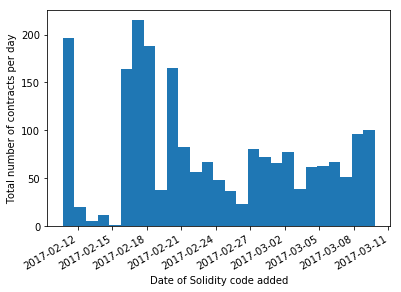

In [9]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
x = time_list
num_bins = difference.days
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins)
ax.set_xlabel('Date of Solidity code added')
ax.set_ylabel('Total number of contracts per day')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

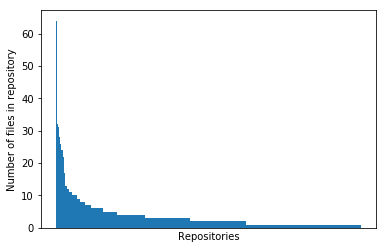

In [29]:
from collections import Counter
import numpy as np
from operator import itemgetter

repositories = code_base.find({},{"repository_id":1, "_id":0})
repo_list = []


for item in repositories:
    repo_list.append(item["repository_id"])
    
repos = Counter(repo_list).items()
repos.sort(key=itemgetter(1), reverse=True)
labels, values = zip(*repos)

indexes = np.arange(len(labels))
width = 1

# the barchart of the data
plt.bar(indexes, values, width)
plt.xlabel('Repositories')
plt.ylabel('Number of files in repository')
plt.xticks([])
plt.show()

### Solidity versions

In [64]:
# Find akeys in nested dictinaries
# Interesting thread on this: http://stackoverflow.com/questions/9807634/find-all-occurences-of-a-key-in-nested-python-dictionaries-and-lists
def gen_dict_extract(key, var):
    if hasattr(var,'iteritems'):
        for k, v in var.iteritems():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in gen_dict_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_dict_extract(key, d):
                        yield result

In [72]:
sol_code = code_base.find({},{"code":1, "_id":0})
sol_list = []

for item in sol_code:
    try:
        version = gen_dict_extract("version", item)
        sol_list.append(list(version)[0])
        # sol_list.append(item["code"]["body"][0]["start_version"]["version"])
    except KeyError:
        pass
    except IndexError:
        pass
# Print number of contracts that include a Solidity version
print len(sol_list)

1697


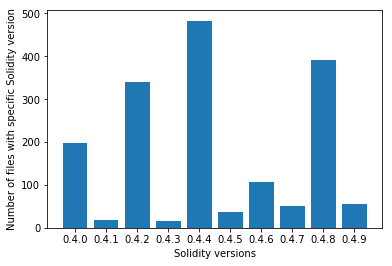

In [73]:
versions = Counter(sol_list).items()
versions.sort(key=itemgetter(0))
labels, values = zip(*versions)

indexes = np.arange(len(labels))
width = 0.8

# the barchart of the data
plt.bar(indexes, values, width)
plt.xlabel('Solidity versions')
plt.ylabel('Number of files with specific Solidity version')
plt.xticks(indexes, labels)
plt.show()

# Analysis of security recommendations
Based on [best pratices by ConsenSys](https://github.com/ConsenSys/smart-contract-best-practices#solidity-tips)

# Analysis of code complexity
Number of variables, mappings, structs, and events per contract

In [87]:
sol_code = code_base.find({},{"code":1, "_id":0})

variables = []
structs = []
events = []
mappings = []
functions = []
libraries = []
enums = []
imports = []

for item in sol_code:
    current_variables = 0
    current_structs = 0
    current_events = 0
    current_mappings = 0
    current_functions = 0
    current_libraries = 0
    current_enums = 0
    current_imports = 0
    for key in gen_dict_extract('type', item):
        if key in 'StateVariableDeclaration':
            current_variables += 1
        elif key in 'StructDeclaration':
            current_structs += 1
        elif key in 'EventDeclaration':
            current_events += 1
        elif key in 'MappingExpression':
            current_mappings += 1
        elif key in 'FunctionDeclaration':
            current_functions += 1
        elif key in 'UsingStatement':
            current_libraries += 1
        elif key in 'EnumDeclaration':
            current_enums += 1
        elif key in 'ImportStatement':
            current_imports += 1     
    variables.append(current_variables)
    structs.append(current_structs)
    events.append(current_events)
    mappings.append(current_mappings)
    functions.append(current_functions)
    libraries.append(current_libraries)
    enums.append(current_enums)
    imports.append(current_imports)
    
all_data = [imports, libraries, variables, events, structs, mappings, enums, functions]

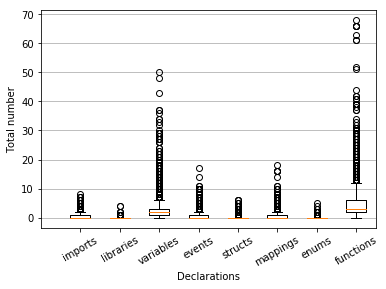

In [88]:
fig, axes = plt.subplots()

axes.boxplot(all_data)

xlabels = ['imports', 'libraries', 'variables', 'events', 'structs', 'mappings', 'enums', 'functions']

axes.yaxis.grid(True)
axes.set_xticks([y for y in range(len(all_data))])
axes.set_xlabel('Declarations')
axes.set_ylabel('Total number')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=xlabels)
plt.xticks(rotation=30)
plt.show()

In [100]:
from statistics import mean, stdev, variance
i = 0
for item in all_data:
    print xlabels[i]
    print "Mean: {}".format(mean(item))
    print "Standard deviation: {}".format(stdev(item))
    print "Variance: {}".format(variance(item))
    print "Outer 90 percentile: {}".format(np.percentile(item,90))
    print "Outer 95 percentile: {}".format(np.percentile(item,95))
    print "Outer 99 percentile: {}".format(np.percentile(item,99))
    print "-------------"
    i += 1

imports
Mean: 0.656145384983
Standard deviation: 1.0675215072
Variance: 1.13960216833
Outer 90 percentile: 2.0
Outer 95 percentile: 3.0
Outer 99 percentile: 4.0
-------------
libraries
Mean: 0.0162601626016
Standard deviation: 0.174234009819
Variance: 0.0303574901778
Outer 90 percentile: 0.0
Outer 95 percentile: 0.0
Outer 99 percentile: 1.0
-------------
variables
Mean: 3.24581539933
Standard deviation: 5.07379282481
Variance: 25.7433736291
Outer 90 percentile: 8.0
Outer 95 percentile: 14.0
Outer 99 percentile: 27.0
-------------
events
Mean: 0.63462458154
Standard deviation: 1.50959501846
Variance: 2.27887711976
Outer 90 percentile: 2.0
Outer 95 percentile: 3.0
Outer 99 percentile: 8.0
-------------
structs
Mean: 0.245337159254
Standard deviation: 0.691417667589
Variance: 0.478058391054
Outer 90 percentile: 1.0
Outer 95 percentile: 2.0
Outer 99 percentile: 3.0
-------------
mappings
Mean: 0.703491152559
Standard deviation: 1.55415241206
Variance: 2.4153897199
Outer 90 percentile: 2.0
